### Multiclass classification Project
- **Learning goals**

    - How to read different size images from a directory ?
    - How to implement 'One-vs-One' scheme for multiclass classification ?
    - How to use SVM for Image classification ?

In [58]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [59]:
p = Path("Images/")

In [60]:
dirs = p.glob("*")
# Mapping to help labeling Images
label_dict = {
    'cat':0,'dog':1,'horse':2,'human':3
}
image_data = []
labels = []
for folder_dir in dirs:

    label = str(folder_dir).split("/")[-1][:-1]

    for img_path in folder_dir.glob('*.jpg'):
        img = image.load_img(img_path,target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dict[label])

In [61]:
print(len(image_data))

808


In [62]:
print(len(labels))


808


In [63]:
# Convert the list into numpy array
image_data = np.array(image_data,dtype='float32')/255
labels = np.array(labels)

In [64]:
image_data.shape

(808, 32, 32, 3)

In [65]:
labels.shape

(808,)

#### Randomly shuffle the data!

In [66]:
import random

In [67]:
combined = list(zip(image_data,labels))
random.shuffle(combined)

In [68]:
image_data[:], labels[:] = zip(*combined)

In [69]:
image_data.shape

(808, 32, 32, 3)

### Visualize the data !

In [70]:
def drawImg(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()


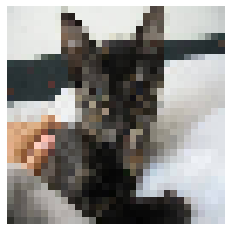

0

In [71]:
drawImg(image_data[0])
labels[0]

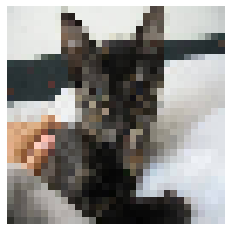

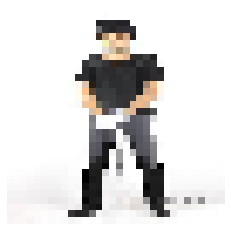

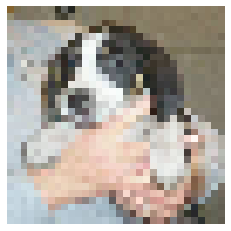

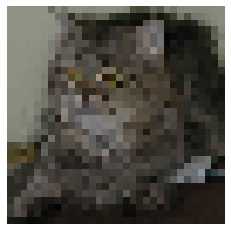

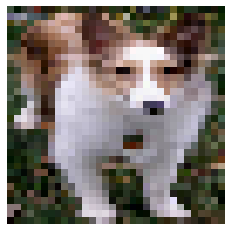

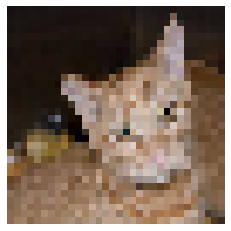

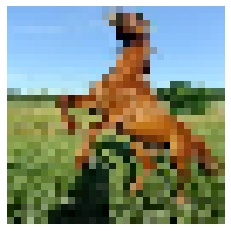

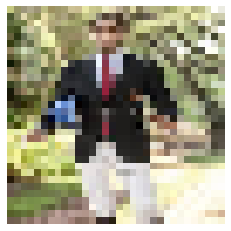

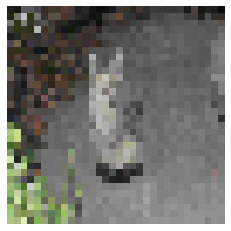

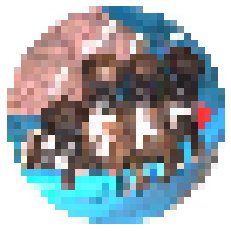

In [72]:
for i in range(10):
    drawImg(image_data[i])

### SVM classifier


In [73]:
class SVM:

    def __init__(self,C=1.0):
        self.C= C
        self.W = 0
        self.b = 0

    def hingeLoss(self,W,b,X,Y):
        loss = 0.0

        loss += 0.5*np.dot(W,W.T)

        m = X.shape[0]

        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C * max(0,(1-ti))

        return loss[0,0]

    def fit(self,X,Y,batch_size=100,learning_rate=0.001,maxiter=300):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]

        n =learning_rate
        c = self.C

        #Init the model parameter
        W =np.zeros((1,no_of_features))
        bias = 0



        # Training from here...
        # Weight and biased update rule -->
        loss_list = []

        for i in range(maxiter):
            # training loop
            l = self.hingeLoss(W,bias,X,Y)
            loss_list.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)

            #Batch Gradient Descent with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                # Assume 0 gradient for the batch
                gradw = 0
                gradb = 0

                #Iterate over all examples in the mini-batch
                for j in range(batch_start,batch_start+batch_size):
                    if j < no_of_samples:
                        i = ids[j]
                        ti = Y[i]*(np.dot(W,X[i].T)+bias)

                        if ti >=1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                # gradient for the Batch is ready

                W = W -n*W + n*gradw
                bias = bias + n*gradb

        self.W = W
        self.b = bias
        return W[0],bias,loss_list

In [74]:
## We need to convert the data for One vs One classification case
M = image_data.shape[0]
image_data = image_data.reshape(M,-1)

In [75]:
image_data.shape

(808, 3072)

In [76]:
CLASSES = len(np.unique(labels))

In [77]:
def classWisedata(x,y):
    data = {}
    for i in range(CLASSES):
        data[i] = []

    for i in range(x.shape[0]):
        data[y[i]].append(x[i])

    for k in data.keys():
        data[k] = np.array(data[k])

    return data

In [78]:
data = classWisedata(image_data,labels)

In [79]:
print(data[0].shape)

(202, 3072)


In [80]:
def getdatapairforsvm(d1,d2):
    l1, l2  = d1.shape[0], d2.shape[0]

    samples = l1+l2
    features = d1.shape[1]

    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    data_labels[:l1] = -1
    data_labels[l1:] = +1

    return data_pair,data_labels

### Training Nc2 SVM's Part

In [81]:
mySVM = SVM()

In [134]:
def trainSVMs(x,y):

    svm_classifier = {}

    for i in range(len(np.unique(y))):
        svm_classifier[i] = {}
        for j in range(i+1,len(np.unique(y))):
            xpair, ypair = getdatapairforsvm(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate=0.00001)
            svm_classifier[i][j] = (wts,b)
    return svm_classifier

In [135]:
svm_classifier = trainSVMs(image_data,labels)

In [136]:
svm_classifier

{0: {1: (array([ 0.01201018,  0.01050107, -0.00351327, ...,  0.01642982,
           0.01582887,  0.01499085]),
   0.009040000000000006),
  2: (array([-0.00753288, -0.00086888, -0.00033791, ...,  0.00755885,
           0.0103037 , -0.00914392]),
   -0.03333999999999998),
  3: (array([0.0103445 , 0.01181803, 0.00467618, ..., 0.01699101, 0.019134  ,
          0.01162417]),
   -0.004550000000000006)},
 1: {2: (array([-0.02071362, -0.01014907,  0.00189478, ..., -0.0093911 ,
          -0.0058805 , -0.02640284]),
   -0.041329999999999985),
  3: (array([-0.00029991,  0.00511805,  0.00897846, ..., -0.00270017,
          -0.00010792, -0.00910096]),
   -0.00954)},
 2: {3: (array([0.02202208, 0.01463615, 0.00754309, ..., 0.01057016, 0.00975303,
          0.01832255]),
   0.031659999999999994)},
 3: {}}

In [137]:
# Parameters for cats and dogs
cat_dog = svm_classifier[0][1]

In [138]:
# weight
cat_dog[0].shape

(3072,)

In [139]:
# biased
cat_dog[1]

0.009040000000000006

### Prediction

In [140]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z >= 0:
        return 1
    else:
        return -1

In [141]:
def predict(x):

    count = np.zeros((CLASSES,))

    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b = svm_classifier[i][j]
            # take a majority prediction
            z = binaryPredict(x,w,b)

            if z >= 1:
                count[j] += 1
            else:
                count[i] += 1
    final_pred = np.argmax(count)
    # print(count)
    return final_pred

In [142]:
predict(image_data[0])

TypeError: predict() takes 1 positional argument but 2 were given

In [ ]:
labels[0]

In [ ]:
def accuracy(x,y):

    count = 0

    for i in range(x.shape[0]):
         prediction = predict(x[i])
         if prediction == y[i]:
             count += 1

    return count/x.shape[0]

In [ ]:
accuracy(image_data,labels)

In [133]:
xp,yp = getdatapairforsvm(data[0],data[1])
w,b,loss = mySVM.fit(xp,yp)

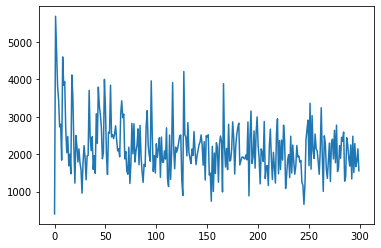

In [121]:
plt.plot(loss)
plt.show()

In [105]:
## Effect of learning rate
xp,yp = getdatapairforsvm(data[0],data[1])
w1,b1,loss = mySVM.fit(xp,yp,learning_rate=0.00001)

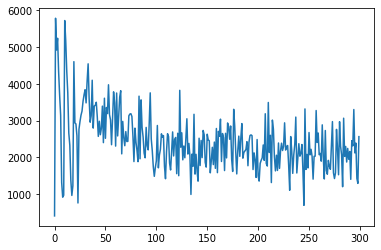

In [106]:
plt.plot(loss)

In [122]:
from sklearn import svm

In [123]:
svm_classifier = svm.SVC(kernel='linear',C=1.0)

In [124]:
svm_classifier.fit(image_data,labels)

SVC(kernel='linear')

In [125]:
svm_classifier.score(image_data,labels)

0.655940594059406